# Recurrent Neural Network - Univariate
- Simple RNN
- LSTM
- GRU
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

## In order to use LSTM and GRU, you need to downgrade numpy
- `conda create --name tf tensorflow=2.4`
- `conda activate tf`
- `conda install numpy=1.19`
- `conda install jupyterlab matplotlib pandas`
- https://stackoverflow.com/questions/66207609/notimplementederror-cannot-convert-a-symbolic-tensor-lstm-2-strided-slice0-t

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.config.list_physical_devices("GPU")

2022-04-26 06:57:28.443017: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


[]

In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [4]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [5]:
# choose a number of time steps
n_steps = 3

In [6]:
# split into samples
X_, y = split_sequence(raw_seq, n_steps)

# visualize input
temp = pd.DataFrame(data=X_, columns=['X1-Time1','X1-Time2','X1-Time3'])
temp['y'] = y
temp.index.name='sample'
display(temp)

,X1-Time1,X1-Time2,X1-Time3,y
sample,,,,
0,10,20,30,40
1,20,30,40,50
2,30,40,50,60
3,40,50,60,70
4,50,60,70,80
5,60,70,80,90


In [7]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X_.reshape((X_.shape[0], X_.shape[1], n_features))
X.shape

(6, 3, 1)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten

def createModel(type):
    inputLayer = Input(shape=(n_steps, n_features))

    if (type == 'RNN'):
        layer = SimpleRNN(50, activation='relu')(inputLayer)
    elif (type == 'LSTM'):
       layer = LSTM(50, activation='relu')(inputLayer)
    elif (type == 'GRU'):
        layer = GRU(50, activation='relu')(inputLayer)
    elif (type == 'CNN'):
        layer = Conv1D(filters=64, kernel_size=2, activation='relu', strides=1, padding='valid')(inputLayer)
        layer = MaxPooling1D(pool_size=2)(layer)
        layer = Flatten()(layer)
        layer = Dense(50, activation='relu')(layer)        

    outputLayer = Dense(1)(layer)
    model = Model(inputs=inputLayer, outputs=outputLayer, name=type)

    return model


In [9]:
# Model building
tf.keras.backend.clear_session()
tf.random.set_seed(1)
# For somereason if I don't include this, I cannot execute this cell twice for LSTM and GRU
from tensorflow.keras.layers import LSTM, GRU

RNN = createModel('RNN')
LSTM = createModel('LSTM')
GRU = createModel('GRU')
CNN = createModel('CNN')

RNN.summary()
LSTM.summary()
GRU.summary()
CNN.summary()

2022-04-26 06:57:28.778385: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 06:57:28.780674: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________
Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10400     
_______________________________________________

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

def runModel(model, X, y, **kwargs):

    learning_rate = 0.001
    if 'learning_rate' in kwargs:
        learning_rate = kwargs['learning_rate']

    patience = 10
    if 'patience' in kwargs:
        patience = kwargs['patience']

    epochs=200
    if 'epochs' in kwargs:
        epochs = kwargs['epochs']

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    earlyStoppingCallback = EarlyStopping(monitor='loss', patience=patience, min_delta=0)

    history = model.fit(X, y, epochs=epochs, verbose=1, callbacks=[earlyStoppingCallback ])

    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    plt.show()

Epoch 1/2000


2022-04-26 06:57:29.207408: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-26 06:57:29.226907: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999965000 Hz


1/1 [==============================] - 1s 883ms/step - loss: 4849.3965
Epoch 2/2000
1/1 [==============================] - 0s 6ms/step - loss: 4633.8560
Epoch 3/2000
1/1 [==============================] - 0s 6ms/step - loss: 4424.1021
Epoch 4/2000
1/1 [==============================] - 0s 6ms/step - loss: 4220.1235
Epoch 5/2000
1/1 [==============================] - 0s 7ms/step - loss: 4020.7166
Epoch 6/2000
1/1 [==============================] - 0s 5ms/step - loss: 3829.0710
Epoch 7/2000
1/1 [==============================] - 0s 6ms/step - loss: 3645.4451
Epoch 8/2000
1/1 [==============================] - 0s 6ms/step - loss: 3468.8606
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 3308.8328
Epoch 10/2000
1/1 [==============================] - 0s 13ms/step - loss: 3159.1223
Epoch 11/2000
1/1 [==============================] - 0s 13ms/step - loss: 3014.5364
Epoch 12/2000
1/1 [==============================] - 0s 14ms/step - loss: 2873.2490
Epoch 13/2000
1/1 [=

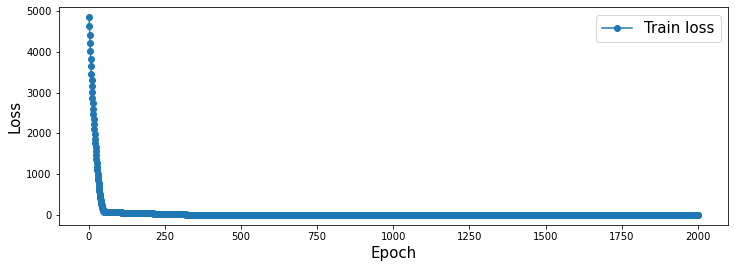

In [11]:
runModel(RNN, X, y, learning_rate=0.001, epochs=2000, patience=30)

Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 4143.3989
Epoch 2/2000
1/1 [==============================] - 0s 28ms/step - loss: 4087.9934
Epoch 3/2000
1/1 [==============================] - 0s 8ms/step - loss: 4033.9277
Epoch 4/2000
1/1 [==============================] - 0s 11ms/step - loss: 3979.7512
Epoch 5/2000
1/1 [==============================] - 0s 6ms/step - loss: 3925.2256
Epoch 6/2000
1/1 [==============================] - 0s 5ms/step - loss: 3870.4426
Epoch 7/2000
1/1 [==============================] - 0s 9ms/step - loss: 3815.4011
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 3760.0774
Epoch 9/2000
1/1 [==============================] - 0s 7ms/step - loss: 3704.4150
Epoch 10/2000
1/1 [==============================] - 0s 12ms/step - loss: 3648.3391
Epoch 11/2000
1/1 [==============================] - 0s 24ms/step - loss: 3591.7424
Epoch 12/2000
1/1 [==============================] - 0s 12ms/step - loss: 3534.4961
Epoch 13

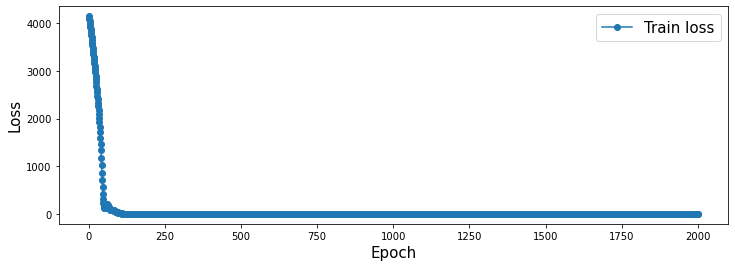

In [12]:
runModel(LSTM, X, y, learning_rate=0.001, epochs=2000, patience=30)

Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 4349.4185
Epoch 2/2000
1/1 [==============================] - 0s 17ms/step - loss: 4326.6528
Epoch 3/2000
1/1 [==============================] - 0s 9ms/step - loss: 4304.1343
Epoch 4/2000
1/1 [==============================] - 0s 16ms/step - loss: 4281.8364
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 4259.7358
Epoch 6/2000
1/1 [==============================] - 0s 18ms/step - loss: 4237.8091
Epoch 7/2000
1/1 [==============================] - 0s 12ms/step - loss: 4216.0391
Epoch 8/2000
1/1 [==============================] - 0s 16ms/step - loss: 4194.3950
Epoch 9/2000
1/1 [==============================] - 0s 13ms/step - loss: 4172.8491
Epoch 10/2000
1/1 [==============================] - 0s 16ms/step - loss: 4151.3735
Epoch 11/2000
1/1 [==============================] - 0s 18ms/step - loss: 4129.9497
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 4108.5425
Epoc

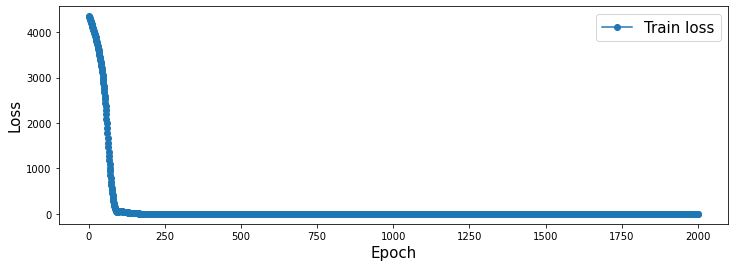

In [13]:
runModel(GRU, X, y, learning_rate=0.001, epochs=2000, patience=30)

Epoch 1/2000
1/1 [==============================] - 1s 510ms/step - loss: 4517.9702
Epoch 2/2000
1/1 [==============================] - 0s 35ms/step - loss: 4398.5996
Epoch 3/2000
1/1 [==============================] - 0s 7ms/step - loss: 4280.8579
Epoch 4/2000
1/1 [==============================] - 0s 17ms/step - loss: 4164.7090
Epoch 5/2000
1/1 [==============================] - 0s 9ms/step - loss: 4050.1086
Epoch 6/2000
1/1 [==============================] - 0s 17ms/step - loss: 3937.0920
Epoch 7/2000
1/1 [==============================] - 0s 6ms/step - loss: 3826.1614
Epoch 8/2000
1/1 [==============================] - 0s 21ms/step - loss: 3719.3447
Epoch 9/2000
1/1 [==============================] - 0s 13ms/step - loss: 3615.4260
Epoch 10/2000
1/1 [==============================] - 0s 5ms/step - loss: 3513.4824
Epoch 11/2000
1/1 [==============================] - 0s 8ms/step - loss: 3412.4055
Epoch 12/2000
1/1 [==============================] - 0s 4ms/step - loss: 3312.6853
Epoch 

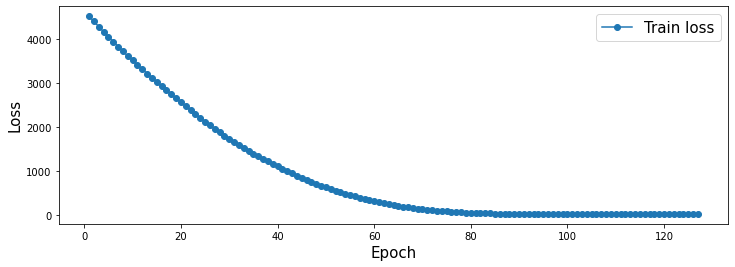

In [14]:
runModel(CNN, X, y, learning_rate=0.0005, epochs=2000, patience=30)

In [15]:
def predictValue(model, X_):
    X = X_.reshape((1, n_steps, n_features))
    yhat_ = model.predict(X, verbose=0)
    yhat = yhat_.flatten()[0]
    return yhat

In [16]:
X_ = np.array([70, 80, 90])
print(f"RNN: {predictValue(RNN, X_):5.3f}")
print(f"LSTM: {predictValue(LSTM, X_):5.3f}")
print(f"GRU: {predictValue(GRU, X_):5.3f}")
print(f"CNN: {predictValue(CNN, X_):5.3f}")

RNN: 100.000
LSTM: 100.220
GRU: 100.390
CNN: 108.141


In [17]:
def calculateForecast(model):
    n_forecast = 10
    Xseq = np.array([60, 70, 80])
    yhat = 90

    yA = np.array([])

    for i in range(n_forecast):
        Xseq = np.append(Xseq[1:3],yhat)
        yhat = predictValue(model, Xseq)
        yA = np.append(yA,yhat)    

    return yA

In [18]:
yRNN = calculateForecast(RNN)
yLSTM = calculateForecast(LSTM)
yGRU = calculateForecast(GRU)
yCNN = calculateForecast(CNN)

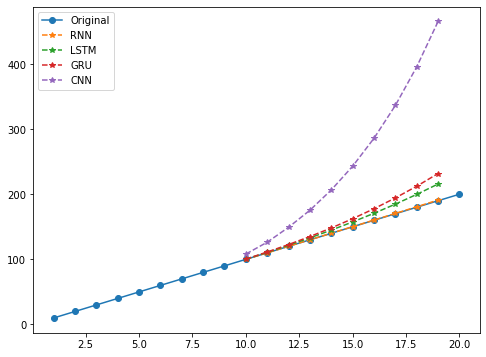

In [19]:
models = [RNN, LSTM, GRU, CNN]
yp2A = [yRNN, yLSTM, yGRU, yCNN]

xp1 = np.arange(20) + 1
yp1 = xp1*10 
xp2 = np.arange(10,20) 

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(xp1,yp1, '-o', label='Original')

for model, yp2 in zip(models,yp2A):
    ax.plot(xp2, yp2,'*--', label=model.name)

ax.legend()

